# Optimization Methods Project Work: SMO and DCD-Linear for training SVM

This notebook will contain some code that implements the SMO and DCD-Linear algorithm, plus the results.

## Testing the environment

The following cell will simply verify if all the libraries necessary to run the code are correctly installed.

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import math
import random

random.seed(91212) # This function allows to replicate the same experiemtns even if the random function is used

print("Everything is good!")

Everything is good!


## Defining the Dual Problem

### The Bias One (For SMO)

As we know, the formulation of the dual problem for training a SVM is:
$$
\begin{gather*}
\min_{\alpha} \frac{1}{2}\alpha^TQ\alpha - e^T\alpha \\
\forall i\ 0 \leq \alpha_i \leq C\ \ \sum \limits_i^n \alpha_iy_i = 0
\end{gather*}
$$

As stated in the Project Goals, we will use the Most Violating Pair rule to select the variables to change. So, to implement this algorithm efficiently, we need those elements:
* A function that calculates the derivatives
* A function that adjust the derivative after changing $\alpha$ 
* A function that extract the most violating pair.

To sum up all this functionality, they will be implemented inside a class. The constructor will receive the set of Xs and Ys, and using that will derive Q.

In [210]:
class DualSVMProblem:

    def __init__(self, Xs, Ys, C, epsilon = 1e-5):
        self.X = Xs
        self.Y = Ys
        self.C = C
        self.a = np.zeros_like(Ys, dtype = float)
        self.e = np.ones_like(self.a)
        self.epsilon = epsilon

        mat = np.stack([Ys.T] * Xs.shape[1], axis = 1)
        
        Z = Xs * mat
        self.Q = Z @ Z.T

        self.d = self.Q @ self.a - self.e

    def getA(self):
        return self.a
        
    def getDerivative(self):
        return self.d    

    def getMostViolatingPair(self):
        directions = self.d / self.Y
        min_idx = -1
        min_value = np.inf
        max_idx = -1
        max_value = -np.inf

        R = directions.copy()
        R[np.logical_and(self.a < self.epsilon, self.Y == -1)] = np.inf
        R[np.logical_and(self.a > self.C - self.epsilon, self.Y == 1)] = np.inf

        S = directions.copy()
        S[np.logical_and(self.a < self.epsilon, self.Y == 1)] = -np.inf
        S[np.logical_and(self.a > self.C - self.epsilon, self.Y == -1)] = -np.inf

        min_idx = np.argmin(R)
        max_idx = np.argmax(S)

        if R[min_idx] == np.inf or S[max_idx] == -np.inf:
            return None
                
        return (min_idx, max_idx)

    def updateA(self, idx1, a1, idx2, a2):
        self.d = self.Q[idx1] * (a1 - self.a[idx1]) + self.Q[idx2] * (a2 - self.a[idx2]) + self.d
        self.a[idx1] = a1
        self.a[idx2] = a2

    def getParameters(self):
        mat = np.stack([self.a.T * self.Y.T] * self.X.shape[1], axis = 1)
        w = np.sum(mat * self.X, axis = 0)
        b = 0
        for i in range(len(self.a)):
            if(self.a[i] < self.epsilon or self.a[i] > self.C - self.epsilon):
                continue
            b = 1 / self.Y[i] - w @ self.X[i]
            break        
        return (w, b)

class SVM:
    def __init__(self, w, b):
        self.w = w
        self.b = b

    def __call__(self, x):
        return np.sign(x @ self.w + self.b)

def loss_svm_obj(svm, C, X, y):
    return loss_svm(svm.w, svm.b, C, X, y)
    
def loss_svm(w, b, C, X, y):
    psi = np.maximum(np.zeros_like(y), np.ones_like(y) - y * (X @ w + np.ones_like(y) * b))
    return 0.5 * (w.T @ w) + C * np.sum(psi)

In [3]:
# Let's test the code with some artificial data
X = np.array([[1, 2, 3], [4, 5, 6]])
Y = np.array([1, -1])
C = 5

# The safe way to calculate matrix Q
Q = np.zeros((2, 2))
for i in range(2):
    for j in range(2):
        Q[i][j] = Y[i] * Y[j] * X[i] @ X[j]

problem = DualSVMProblem(X, Y, C)

ok = True
if ((Q != problem.Q).all()):
    ok = False
    print("The matix calculation is wrong")
    
if ((np.array([-1, -1]) != problem.getDerivative()).all()):
    ok = False
    print("The derivative function if wrong")

update = np.array([1, 2])
problem.updateA(0, update[0], 1, update[1])

if ((Q @ update - np.ones(2) != problem.getDerivative()).all()):
    ok = False
    print("The updates of variables doesn't update the derivative in the right way")

elements = problem.getDerivative() / Y

if not (problem.getMostViolatingPair()[0] == (0 if elements[0] < elements[1] else 1) and problem.getMostViolatingPair()[1] == (0 if elements[0] > elements[1] else 1)):
    ok = False
    print("The calculation of the most violating pair is wrong")
    # This test is a bit odd and not exaustive, but can help

if ok:
    print("Everything is working as expected!")

Everything is working as expected!


## Implementation of SMO

After implementing core elements for the SMO algorithm, it's time to get them together and build the actual result.
In this implementation, I realized a function that execute a single iteration of the algorithm, leaving the check of convergence outside. The objective is to reuse the external function with the different approach (DCD-Linear), and then make easier to instrument the code to measure some components like loss, validation, etc.

In [64]:
from typing import Callable
def trainingSMO(problem: DualSVMProblem, step: Callable[[DualSVMProblem], bool], loss_func: Callable[[SVM], float] = None, validation_func: Callable[[SVM], float] = None, epsilon = 1e-5, verbose = False):
    loss = []
    validation = []
    
    while(True): 
        (min_idx, max_idx) = problem.getMostViolatingPair()
        elements = problem.getDerivative() / problem.Y

        if verbose:
            print(f"Stopping condition: {elements[max_idx] - elements[min_idx]}")
        if(elements[min_idx] + epsilon > elements[max_idx]):
            break
        
        result = step(problem)            
        (w, b) = problem.getParameters()
        svm = SVM(w, b)
        
        if(loss_func is not None):
            loss.append(loss_func(svm))
    
        if(validation_func is not None):
            validation.append(validation_func(svm))

        if not result:
            # If the step method give False as a result indicates an error or a stop condition (i.e. having a derivative under the tollerance)
            break

    return (loss, validation)

def SMO_step(problem: DualSVMProblem, epsilon: float = 1e-5):
    test = problem.getMostViolatingPair()
    if(test is None):
        raise Exception("The problem did not give a valid violating pair")
    (min_idx, max_idx) = (test[0], test[1])

    direction = np.zeros_like(problem.a)
    direction[min_idx] = 1 * problem.Y[min_idx]
    direction[max_idx] = - 1 * problem.Y[max_idx] #In theory I should divide, but y is in {-1, 1} making the multiplication equivalent, but more efficient

    derivative = problem.getDerivative()

    b = problem.C - problem.a[min_idx] if direction[min_idx] > 0 else problem.a[min_idx]
    b = min(b, problem.C - problem.a[max_idx] if direction[max_idx] > 0 else problem.a[max_idx])
    
    if b < epsilon:
        return False

    value = direction.T @ problem.Q @ direction

    if value > epsilon:
        b = min(b, -(derivative.T @ direction) / value)

    problem.updateA(min_idx, problem.a[min_idx] + b * direction[min_idx], max_idx, problem.a[max_idx] + b * direction[max_idx])
    return True    

## Testing the Code

In the following cells, I will use a very simple classification problem to see if the code works at all. [This dataset](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#breast-cancer) is composed by only 683 elements, everyone of only 10 features. This dataset is chosen dues to it contained dimension. In fact, this implementation of the Dual SVM explicitly calculate the Q matrix, something that can become prohibitive very quickly in the increase of elements.

In [59]:
from sklearn.datasets import load_svmlight_file
from sklearn.datasets import dump_svmlight_file
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

(Xs, Ys) = load_svmlight_file("datasets/breast_cancer_scale")
Ys[Ys == 2] = 1
Ys[Ys == 4] = -1 # TODO control the description to decide what is positive and what is negative

Xs = Xs.toarray()

Xs 

dump_svmlight_file(Xs, Ys, "datasets/breast_cancer_ones")

# There is a lot to say (Xs originally is a sparce matrix, not scaled values broke the model, Ys classes are 2 and 4)

In [60]:
(train_Xs, test_Xs, train_Ys, test_Ys)  = train_test_split(Xs, Ys, test_size = 0.20)

base_svm = LinearSVC(C = 10)
base_svm.fit(train_Xs, train_Ys)

train_preds = base_svm.predict(train_Xs)
test_preds = base_svm.predict(test_Xs)


print("Report on train set:")
print(classification_report(train_Ys, train_preds, zero_division = 0))

print("Report on test set:")
print(classification_report(test_Ys, test_preds, zero_division = 0))

Report on train set:
              precision    recall  f1-score   support

        -1.0       0.96      0.96      0.96       194
         1.0       0.98      0.98      0.98       352

    accuracy                           0.97       546
   macro avg       0.97      0.97      0.97       546
weighted avg       0.97      0.97      0.97       546

Report on test set:
              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99        45
         1.0       1.00      0.99      0.99        92

    accuracy                           0.99       137
   macro avg       0.99      0.99      0.99       137
weighted avg       0.99      0.99      0.99       137



In [61]:
base_smo_problem = DualSVMProblem(train_Xs, train_Ys, C = 10)

(_, _) = trainingSMO(base_smo_problem, SMO_step, epsilon = 1e-2)

(w, b) = base_smo_problem.getParameters()
smo_svm = SVM(w, b)
smo_train_preds = smo_svm(train_Xs)
smo_test_preds = smo_svm(test_Xs)

print("Result of the model trained using SMO on training set:")
print(classification_report(train_Ys, smo_train_preds, zero_division=0))

print("Result of the model trained using SMO on test set:")
print(classification_report(test_Ys, smo_test_preds, zero_division=0))

Result of the model trained using SMO on training set:
              precision    recall  f1-score   support

        -1.0       0.95      0.96      0.95       194
         1.0       0.98      0.97      0.97       352

    accuracy                           0.97       546
   macro avg       0.96      0.97      0.96       546
weighted avg       0.97      0.97      0.97       546

Result of the model trained using SMO on test set:
              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99        45
         1.0       1.00      0.99      0.99        92

    accuracy                           0.99       137
   macro avg       0.99      0.99      0.99       137
weighted avg       0.99      0.99      0.99       137



In [62]:
from numpy.linalg import norm

print(f"Difference in norm of w: {norm(w - base_svm.coef_)}")
print(f'"Correlation" between the direction of ws : {(w.T @ base_svm.coef_[0]) / (norm(w) * norm(base_svm.coef_))}')
print(f"Difference in the value b: {abs(b - base_svm.intercept_)}")

Difference in norm of w: 1.0075583033754831
"Correlation" between the direction of ws : 0.93258119323886
Difference in the value b: [1.53561506]


## DCD Linear

After implementing the SMO algorithm, now it's time to implement the DCD version. To maintain the uniformity in the problem definition, I will implement the dual formulation of the L1-SVM problem. 

In [9]:
class DCDDualProblem:

    def __init__(self, Xs, Ys, C, epsilon = 1e-5):
        self.X = Xs
        self.Y = Ys
        self.C = C
        self.a = np.zeros_like(Ys, dtype = float)
        self.e = np.ones_like(Ys)
        self.diagQ = np.pow(np.sum(np.pow(Xs, 2), axis = 1, dtype = float), -1) #Inverse Diagonal of Q

        self.w = np.zeros(Xs.shape[1], dtype = float)

        self.epsilon = epsilon

    def optimizeOver(self, index):
        G = self.Y[index] * self.w.T @ self.X[index] - 1

        if self.a[index] < self.epsilon:
            PG = min(G, 0)
        elif self.a[index] > self.C - self.epsilon:
            PG = max(G, 0)
        else:
            PG = G

        if abs(PG) < self.epsilon:
            return

        new_a = min(max(self.a[index] - G * self.diagQ[index], 0), self.C) #Notice that during initialization of the class diagQ is already inverted. In this way the code should be more efficient
        self.w = self.w + (new_a - self.a[index]) * self.Y[index] * self.X[index]
        self.a[index] = new_a

    def getProjectedDerivative(self):
        derivative = self.Y * (self.X @ self.w) - self.e
        derivative[np.logical_and(self.a < self.epsilon, derivative > -self.epsilon)] = 0
        derivative[np.logical_and(self.a > C - self.epsilon, derivative < self.epsilon)] = 0
        return derivative

    def getParameters(self):
        return self.w


### Performing some tests

In [10]:
# Let's test the code with some artificial data
X = np.array([[1, 2, 3], [4, 5, 6]])
Y = np.array([1, -1])
C = 5

diagQ = np.array([1 / (X[0].T @ X[0]), 1 / (X[1].T @ X[1])])

problem = DCDDualProblem(X, Y, C)

ok = True
if (not (diagQ == problem.diagQ).all()):
    ok = False
    print("The diagonal of the matix is wrong")

if (not (-np.ones(2) == problem.getProjectedDerivative()).all()):
    ok = False
    print("The derivative calcultaion is wrong (in the initial state)")

problem.optimizeOver(0)

if (not (np.array([1 / 14, 0]) == problem.a).all()):
    ok = False
    print("The optimization function doesn't work.")

derivative = np.array([Y[i] * problem.w.T @ X[i] - 1 for i in range(X.shape[0])])
if (not (derivative == problem.getProjectedDerivative()).all()):
    ok = False
    print("The derivative calcultaion is wrong (after update)")

if (norm(np.array([1, 2, 3]) / 14 - problem.w) > 10e-5):
    ok = False
    print(f"The w is wrong {problem.w}")

### Tests on second update
problem.optimizeOver(1)
if (norm(np.array([1, 46 / 77]) / 14 - problem.a) > 1e-5):
    ok = False
    print("The optimization function doesn't work (second update).")

derivative = np.array([Y[i] * problem.w.T @ X[i] - 1 for i in range(X.shape[0])])
if (norm(derivative - problem.getProjectedDerivative()) > 1e-5):
    ok = False
    print("The derivative calcultaion is wrong (second update)")

if ok:
    print("Everything is working as expected!")


Everything is working as expected!


### Actual Training

In [11]:
def trainingDCD(problem: DCDDualProblem, loss_func: Callable[[SVM], float] = None, validation_func: Callable[[SVM], float] = None, epsilon = 10e-5, verbose: bool = False):
    loss = []
    validation = []
    j = 0
    while(norm(problem.getProjectedDerivative()) > epsilon):
        if verbose:
            print(f"Norm:{norm(problem.getProjectedDerivative())}")
        j+=1
        for i in np.random.permutation(len(problem.a)):
            problem.optimizeOver(i)
            w = problem.getParameters()
            svm = SVM(w, 0)
            
            if(loss_func is not None):
                loss.append(loss_func(svm))
        
            if(validation_func is not None):
                validation.append(validation_func(svm))
                
    return (loss, validation)

In [12]:
explicit_bias_train = np.atleast_2d(np.ones(train_Xs.shape[0])).T
explicit_bias_test = np.atleast_2d(np.ones(test_Xs.shape[0])).T

train_Xs_unbiased = np.hstack([train_Xs, explicit_bias_train])
test_Xs_unbiased = np.hstack([test_Xs, explicit_bias_test])

print(train_Xs_unbiased.shape)

(546, 11)


In [13]:
base_dcd_problem = DCDDualProblem(train_Xs_unbiased, train_Ys, C = 10)

(_, _) = trainingDCD(base_dcd_problem, epsilon = 1e-2)

In [14]:
w = base_dcd_problem.getParameters()

dcd_svm = SVM(w, 0)
dcd_train_preds = dcd_svm(train_Xs_unbiased)
dcd_test_preds = dcd_svm(test_Xs_unbiased)

print("Result of the model trained using DCD on training set:")
print(classification_report(train_Ys, dcd_train_preds, zero_division=0))

print("Result of the model trained using DCD on test set:")
print(classification_report(test_Ys, dcd_test_preds, zero_division=0))

Result of the model trained using DCD on training set:
              precision    recall  f1-score   support

        -1.0       0.95      0.96      0.95       196
         1.0       0.98      0.97      0.97       350

    accuracy                           0.97       546
   macro avg       0.96      0.97      0.96       546
weighted avg       0.97      0.97      0.97       546

Result of the model trained using DCD on test set:
              precision    recall  f1-score   support

        -1.0       1.00      0.95      0.98        43
         1.0       0.98      1.00      0.99        94

    accuracy                           0.99       137
   macro avg       0.99      0.98      0.98       137
weighted avg       0.99      0.99      0.99       137



## Performing comparative test on speed

In [224]:
(Xs, Ys) = load_svmlight_file("datasets/madelon")
Xs = Xs.toarray()

median = np.stack([(minmax[0] + minmax[1]) / 2] * Xs.shape[0])
half_interval = np.stack([(minmax[0] - minmax[1]) / 2] * Xs.shape[0])
Xs = (Xs - median) / half_interval

dump_svmlight_file(Xs, Ys, "datasets/madelon_scaled")

In [229]:
import os

def load_dataset(name: str, dimension = None, features = None):
    bias = load_svmlight_file(name)
    bias = (bias[0].toarray(), bias[1])

    if(dimension is not None):
        permutation = np.random.permutation(bias[0].shape[0])

        indexs = permutation[0:dimension]
        bias = (bias[0][indexs], bias[1][indexs])

    if features is not None:        
        permutation = np.random.permutation(bias[0].shape[1])

        indexs = permutation[0:features]
        bias = (bias[0].T[indexs].T, bias[1])
    
    new_column = np.atleast_2d(np.ones(bias[0].shape[0])).T
    unbias = (np.hstack([bias[0], new_column]), bias[1])

    return (bias, unbias)

features = [100, 200, 300, 400, 500]
dimensions = [100, 200, 300, 400, 500]
thresholds = [1e-1, 1e-2, 1e-3, 1e-4]
dataset = "datasets/breast_cancer_ones"

dimension = 300
threshold = 1e-4
C = 5
num_experiments = 5

if not os.path.exists("Results"):
    os.mkdir("Results")

In [230]:
import time
import json

smo_results_dimensions = {}
smo_results_dimensions["dimensions"] = dimensions
smo_results_dimensions["thresholds"] = threshold
smo_results_dimensions["times"] = []
smo_results_dimensions["loss"] = []

dcd_results_dimensions = {}
dcd_results_dimensions["dimensions"] = dimensions
dcd_results_dimensions["thresholds"] = threshold
dcd_results_dimensions["times"] = []
dcd_results_dimensions["loss"] = []

for d in dimensions:
    (bias, unbias) = load_dataset(dataset, dimension = d)

    smo_total_time = 0
    dcd_total_time = 0

    smo_total_loss = 0
    dcd_total_loss = 0
    
    print(f"Dataset dimension: {d}",f"\tThreshold: {threshold}")
    for n in range(num_experiments):
        
        smo_start_time = time.time()
        smo_problem = DualSVMProblem(bias[0], bias[1], C = C)        
        (_, _) = trainingSMO(smo_problem, SMO_step, epsilon = threshold)
        smo_total_time += time.time() - smo_start_time
        
        (w, b) = smo_problem.getParameters()
        smo_total_loss += loss_svm(w, b, C, bias[0], bias[1])
        
        dcd_start_time = time.time()
        dcd_problem = DCDDualProblem(unbias[0], unbias[1], C = C)
        (_, _) = trainingDCD(dcd_problem, epsilon = threshold)
        dcd_total_time += time.time() - dcd_start_time
        
        w = dcd_problem.getParameters()
        dcd_total_loss += loss_svm(w, 0, C, unbias[0], unbias[1])
        
    smo_results_dimensions["loss"].append(smo_total_loss / num_experiments)
    smo_results_dimensions["times"].append(smo_total_time / num_experiments)
    
    dcd_results_dimensions["loss"].append(dcd_total_loss / num_experiments)
    dcd_results_dimensions["times"].append(dcd_total_time / num_experiments)
        
print("Test Finished")       

Dataset dimension: 100 	Threshold: 0.0001
Dataset dimension: 200 	Threshold: 0.0001
Dataset dimension: 300 	Threshold: 0.0001
Dataset dimension: 400 	Threshold: 0.0001
Dataset dimension: 500 	Threshold: 0.0001
Test Finished


In [231]:
smo_file = open("Results/smo_dimension.json", "w")
smo_file.write(json.dumps(smo_results_dimensions, indent = 2))
smo_file.close()

dcd_file = open("Results/dcd_dimension.json", "w")
dcd_file.write(json.dumps(dcd_results_dimensions, indent = 2))
dcd_file.close()

In [232]:
smo_results_threshols = {}
smo_results_threshols["dimensions"] = dimension
smo_results_threshols["thresholds"] = thresholds
smo_results_threshols["times"] = []
smo_results_threshols["loss"] = []

dcd_results_threshols = {}
dcd_results_threshols["dimensions"] = dimension
dcd_results_threshols["thresholds"] = thresholds
dcd_results_threshols["times"] = []
dcd_results_threshols["loss"] = []


(bias, unbias) = load_dataset(dataset, dimension = dimension)
for t in thresholds:
    
    smo_total_time = 0
    dcd_total_time = 0

    smo_total_loss = 0
    dcd_total_loss = 0
    
    print(f"Dataset dimension: {dimension}",f"\tThreshold: {t}")
    for n in range(num_experiments):
        
        smo_start_time = time.time()
        smo_problem = DualSVMProblem(bias[0], bias[1], C = C)        
        (_, _) = trainingSMO(smo_problem, SMO_step, epsilon = threshold)
        smo_total_time += time.time() - smo_start_time
        
        (w, b) = smo_problem.getParameters()
        smo_total_loss += loss_svm(w, b, C, bias[0], bias[1])
        
        dcd_start_time = time.time()
        dcd_problem = DCDDualProblem(unbias[0], unbias[1], C = C)
        (_, _) = trainingDCD(dcd_problem, epsilon = threshold)
        dcd_total_time += time.time() - dcd_start_time
        
        w = dcd_problem.getParameters()
        dcd_total_loss += loss_svm(w, 0, C, unbias[0], unbias[1])
        
    smo_results_threshols["loss"].append(smo_total_loss / num_experiments)
    smo_results_threshols["times"].append(smo_total_time / num_experiments)
    
    dcd_results_threshols["loss"].append(dcd_total_loss / num_experiments)
    dcd_results_threshols["times"].append(dcd_total_time / num_experiments)
        
print("Test Finished")

Dataset dimension: 300 	Threshold: 0.1
Dataset dimension: 300 	Threshold: 0.01
Dataset dimension: 300 	Threshold: 0.001
Dataset dimension: 300 	Threshold: 0.0001
Test Finished


In [233]:
smo_file = open("Results/smo_threshold.json", "w")
smo_file.write(json.dumps(smo_results_threshols, indent = 2))
smo_file.close()

dcd_file = open("Results/dcd_threshold.json", "w")
dcd_file.write(json.dumps(dcd_results_threshols, indent = 2))
dcd_file.close()

In [234]:
smo_results_features = {}
smo_results_features["dimensions"] = dimension
smo_results_features["thresholds"] = threshold
smo_results_features["features"] = features
smo_results_features["times"] = []
smo_results_features["loss"] = []

dcd_results_features = {}
dcd_results_features["dimensions"] = dimension
dcd_results_features["thresholds"] = threshold
dcd_results_features["features"] = features
dcd_results_features["times"] = []
dcd_results_features["loss"] = []

for f in features:
    
    smo_total_time = 0
    dcd_total_time = 0

    smo_total_loss = 0
    dcd_total_loss = 0
    
    (bias, unbias) = load_dataset("datasets/madelon_scaled", dimension = dimension, features = f)
    print(f"Dataset dimension: {dimension}",f"\tThreshold: {threshold}", f"\tFeatures {f}")
    for n in range(num_experiments):
        
        smo_start_time = time.time()
        smo_problem = DualSVMProblem(bias[0], bias[1], C = C)        
        (_, _) = trainingSMO(smo_problem, SMO_step, epsilon = threshold)
        smo_total_time += time.time() - smo_start_time
        
        (w, b) = smo_problem.getParameters()
        smo_total_loss += loss_svm(w, b, C, bias[0], bias[1])
        
        dcd_start_time = time.time()
        dcd_problem = DCDDualProblem(unbias[0], unbias[1], C = C)
        (_, _) = trainingDCD(dcd_problem, epsilon = threshold)
        dcd_total_time += time.time() - dcd_start_time
        
        w = dcd_problem.getParameters()
        dcd_total_loss += loss_svm(w, 0, C, unbias[0], unbias[1])
        
    smo_results_features["loss"].append(smo_total_loss / num_experiments)
    smo_results_features["times"].append(smo_total_time / num_experiments)
    
    dcd_results_features["loss"].append(dcd_total_loss / num_experiments)
    dcd_results_features["times"].append(dcd_total_time / num_experiments)
        
print("Test Finished")

Dataset dimension: 300 	Threshold: 0.0001 	Features 100
Dataset dimension: 300 	Threshold: 0.0001 	Features 200
Dataset dimension: 300 	Threshold: 0.0001 	Features 300
Dataset dimension: 300 	Threshold: 0.0001 	Features 400
Dataset dimension: 300 	Threshold: 0.0001 	Features 500
Test Finished


In [235]:
smo_file = open("Results/smo_features.json", "w")
smo_file.write(json.dumps(smo_results_features, indent = 2))
smo_file.close()

dcd_file = open("Results/dcd_features.json", "w")
dcd_file.write(json.dumps(dcd_results_features, indent = 2))
dcd_file.close()

## Results Over Dimension

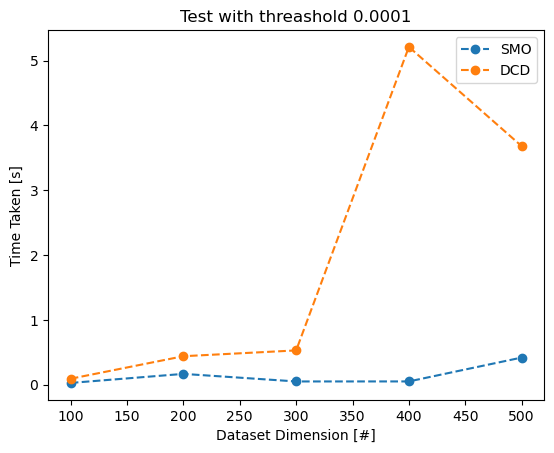

In [236]:
fig, ax = plt.subplots()

smo_file = open("Results/smo_dimension.json", "r")
smo_results = json.loads(smo_file.read())
smo_file.close()

dcd_file = open("Results/dcd_dimension.json", "r")
dcd_results = json.loads(dcd_file.read())
dcd_file.close()

plt.plot(smo_results["dimensions"], smo_results["times"], label = "SMO", marker='o', linestyle='dashed')
plt.plot(dcd_results["dimensions"], dcd_results["times"], label = "DCD", marker='o', linestyle='dashed')

plt.xlabel("Dataset Dimension [#]")
plt.ylabel("Time Taken [s]")
plt.title(f"Test with threashold {smo_results["thresholds"]}")

plt.legend()

## Results Over Threshold

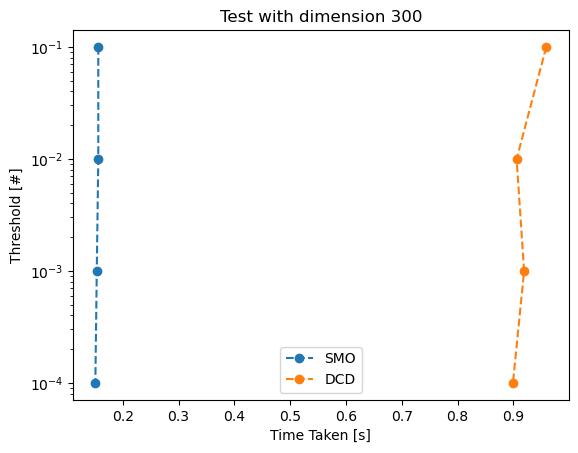

In [237]:
fig, ax = plt.subplots()

smo_file = open("Results/smo_threshold.json", "r")
smo_results = json.loads(smo_file.read())
smo_file.close()

dcd_file = open("Results/dcd_threshold.json", "r")
dcd_results = json.loads(dcd_file.read())
dcd_file.close()

plt.plot(smo_results["times"], smo_results["thresholds"], label = "SMO", marker='o', linestyle='dashed')
plt.plot(dcd_results["times"], dcd_results["thresholds"], label = "DCD", marker='o', linestyle='dashed')

plt.ylabel("Threshold [#]")
plt.xlabel("Time Taken [s]")
plt.title(f"Test with dimension {smo_results["dimensions"]}")

ax.set_yscale("log")

plt.legend()

## Results Over Features

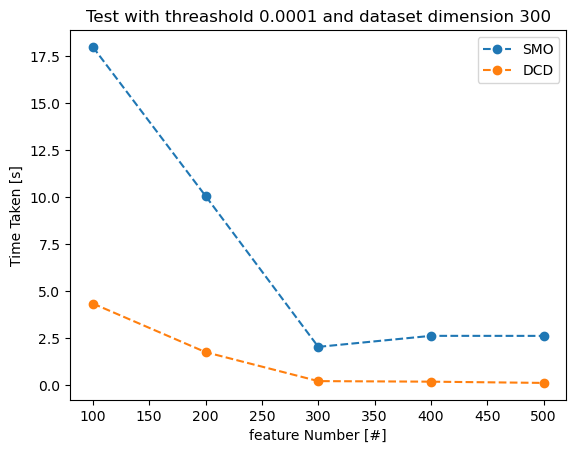

In [238]:
fig, ax = plt.subplots()

smo_file = open("Results/smo_features.json", "r")
smo_results = json.loads(smo_file.read())
smo_file.close()

dcd_file = open("Results/dcd_features.json", "r")
dcd_results = json.loads(dcd_file.read())
dcd_file.close()

plt.plot(smo_results["features"], smo_results["times"], label = "SMO", marker='o', linestyle='dashed')
plt.plot(dcd_results["features"], dcd_results["times"], label = "DCD", marker='o', linestyle='dashed')

plt.xlabel("feature Number [#]")
plt.ylabel("Time Taken [s]")
plt.title(f"Test with threashold {smo_results["thresholds"]} and dataset dimension {smo_results["dimensions"]}")

plt.legend()

## Test On loss decreasing

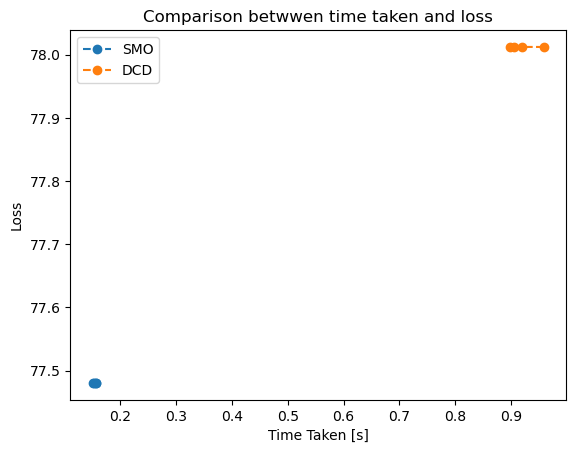

In [239]:
fig, ax = plt.subplots()

smo_file = open("Results/smo_threshold.json", "r")
smo_results = json.loads(smo_file.read())
smo_file.close()

dcd_file = open("Results/dcd_threshold.json", "r")
dcd_results = json.loads(dcd_file.read())
dcd_file.close()

plt.plot(smo_results["times"], smo_results["loss"], label = "SMO", marker='o', linestyle='dashed')
plt.plot(dcd_results["times"], dcd_results["loss"], label = "DCD", marker='o', linestyle='dashed')

plt.ylabel("Loss")
plt.xlabel("Time Taken [s]")
plt.title(f"Comparison betwwen time taken and loss")

plt.legend()

In [240]:
C = 10
threshold = 1e-2
dataset = "datasets/madelon_scaled"

(bias, unbias) = load_dataset(dataset, dimension = d)

print("Testing SMO")
smo_problem = DualSVMProblem(bias[0], bias[1], C = C)        
(smo_loss, _) = trainingSMO(smo_problem, SMO_step, epsilon = threshold, loss_func = lambda x : loss_svm_obj(x, C, bias[0], bias[1]))

print("Testing DCD")
dcd_problem = DCDDualProblem(unbias[0], unbias[1], C = C)
(dcd_loss, _) = trainingDCD(dcd_problem, epsilon = threshold, loss_func = lambda x : loss_svm_obj(x, C, unbias[0], unbias[1]))

print("Test Finished")       

Testing SMO
Testing DCD
Test Finished


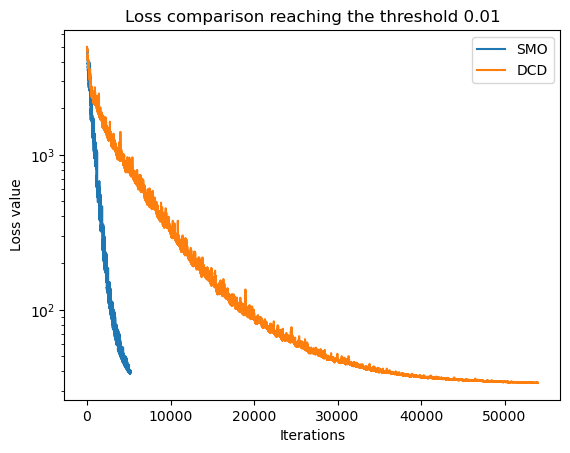

In [241]:
fig, ax = plt.subplots()

plt.plot(smo_loss, label = "SMO")
plt.plot(dcd_loss, label = "DCD")

plt.xlabel("Iterations")
plt.ylabel("Loss value")
plt.legend()
plt.title(f"Loss comparison reaching the threshold {threshold}")

ax.set_yscale("log")